# Python Website Reader

Mit diesem Notebook werden die folgenden Websites besucht und die News in Markdown angezeigt und können auch als Markdown-file abgespeichert werden.

Der Pfad und der Filename kann in der aufrufenden Function savefile('D:\\temp', 'srf.md', stream) angepasst werden. Aktuell ist die Function auskommentiert.

<mark>**Bitte zuerst die class colors ausführen, damit die Farben für den Output geladen sind.**</mark>

In [3]:
class colors: 
    '''Colors class:reset all colors with colors.reset'''

    reset         = '\033[0m'
    bold          = '\033[01m'
    disable       = '\033[02m'
    underline     = '\033[04m'
    reverse       = '\033[07m'
    strikethrough = '\033[09m'
    invisible     = '\033[08m'

    class fg: 
        ''' Define the foreground-colors
        use as colors.fg.colorname
        '''
        black      = '\033[30m'
        red        = '\033[31m'
        green      = '\033[32m'
        orange     = '\033[33m'
        blue       = '\033[34m'
        purple     = '\033[35m'
        cyan       = '\033[36m'
        lightgrey  = '\033[37m'
        darkgrey   = '\033[90m'
        lightred   = '\033[91m'
        lightgreen = '\033[92m'
        yellow     = '\033[93m'
        lightblue  = '\033[94m'
        pink       = '\033[95m'
        lightcyan  = '\033[96m'

    class bg: 
        ''' Define the background-colors
        use as colors.bg.colorname
        '''
        black     = '\033[40m'
        red       = '\033[41m'
        green     = '\033[42m'
        orange    = '\033[43m'
        blue      = '\033[44m'
        purple    = '\033[45m'
        cyan      = '\033[46m'
        lightgrey = '\033[47m'


## SRF News
Code mit <mark> Run Cell </mark> ausführen um die SRF News anzuzeigen.

In [ ]:
news = ['https://www.srf.ch/news/neuste-beitraege']

def newsreader(url, links=True, images=True, emphasis=True):
    '''Reads the given url and print a markdown'''
    import requests, html2text, re
    from datetime import datetime
    now = datetime.now()

    response = requests.get(url)
    if(response.status_code == 200):

        print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {site}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)

        html = response.content.decode('utf-8')

        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        
        data  = md.handle(html)

        #read from '## Inhalt'
        start = data.find('###  Neueste Beiträge')
        end   = data.find('## Footer')
        stream = [(data[start:end])]
        #print(data)

        for i in stream:
            if(i is not None):
                line = i.replace('Mit Video\n\n','').replace('Mit Audio\n\n','')
                if str.startswith(line, '*'):
                    print('{0}{1}{2}'.format(colors.fg.lightred, line, colors.reset))
                else:
                    print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))


        return stream

def savefile(filepath, filename, stream):
    '''Save the stream to the file'''
    import os

    if not os.path.exists(filepath):
        os.makedirs(filepath)

    file = open(filepath + '\\' + filename, 'w')
    for i in stream:
        file.write(i)

    file.close()

for site in news:
    stream = newsreader(site, False, False)
    #savefile('D:\\temp', 'srf.md', stream)


## BAG Covid-⁠19 Schweiz
Code mit <mark> Run Cell </mark> ausführen um die aktuellen Covidzahlen vom BAG anzuzeigen.

In [4]:
news = ['https://www.covid19.admin.ch/de/overview']

def newsreader(url, links=True, images=True, emphasis=True):
    '''Reads the given url and print a markdown'''
    import requests, html2text, re
    from datetime import datetime
    now = datetime.now()

    response = requests.get(url)
    if(response.status_code == 200):

        print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {site}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)

        html = response.content.decode('utf-8')

        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        
        data  = md.handle(html)
        #print(data)

        #read from '## Inhalt'
        start = data.find('### Laborbestätigte Fälle')
        end   = data.find('### Tests und Anteil positive Tests')
        stream = [(data[start:end])]

        for i in stream:
            if(i is not None):

                line = i.replace('Detailinformationen\n\n','')
                line = line.replace('7-⁠Tage-⁠Schnitt\n\n','')
                line = line.replace('Beschreibungen einblenden\n\n','')
                line = line.replace('Neu gemeldet\n\n','')
                line = line.replace('\nFälle\n','')

                print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))

        return stream

def savefile(filepath, filename, stream):
    '''Save the stream to the file'''
    import os

    if not os.path.exists(filepath):
        os.makedirs(filepath)

    file = open(filepath + '\\' + filename, 'w')
    for i in stream:
        file.write(i)

    file.close()

for site in news:
    stream = newsreader(site, False, False)
    #savefile('D:\\temp', 'srf.md', stream)


>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
2021-04-06 14:21:00 NEWS FROM: https://www.covid19.admin.ch/de/overview
<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

### Laborbestätigte Fälle

Quelle: BAG – Stand: 06.04.2021, 07.51h

Differenz zum Freitag| 4932  
---|---  
Total seit 23.03.2021| 23 403  
Pro 100 000 Einwohner/innen| 270,72  
  
### Laborbestätigte Hospitalisationen

Quelle: BAG – Stand: 06.04.2021, 07.51h

Differenz zum Freitag| 175  
---|---  
Total seit 23.03.2021| 638  
Pro 100 000 Einwohner/innen| 7,38  
  
### Laborbestätigte Todesfälle

Quelle: BAG – Stand: 06.04.2021, 07.51h

Differenz zum Freitag| 20  
---|---  
Total seit 23.03.2021| 102  
Pro 100 000 Einwohner/innen| 1,18  
  



### MongoDB

Code mit <mark>Run Cell</mark> ausführen um die Daten in die MongoDB abzuspeichern.

In [1]:
news = 'https://www.covid19.admin.ch/de/overview'

def get_htmldata(url, search_from, search_to, links=True, images=True, emphasis=True):
    import requests, html2text, re
    response = requests.get(url)
    if(response.status_code == 200):
        html = response.content.decode('utf-8')
        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        data  = md.handle(html)

        start  = data.find(search_from)
        end    = data.find(search_to)
        stream = [(data[start:end])]

    return stream


def add_document(connectionstring, mongodatabase, collection, document):
    '''Connect to MongoDB and add a document'''
    import pymongo, dns
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[mongodatabase]
    mongo_col    = mongo_db[collection]
    mongo_col.insert_one(document)
    mongo_client.close()


#process
import re
import pandas as pd

credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"

list_html = get_htmldata(news, '### Laborbestätigte Fälle', '### Laborbestätigte Hospitalisationen')
for line in list_html:
    if(line is not None):
        if re.search('Freitag',line):
            Datum = (re.findall('\w+\:\s\d{2}\.\d{2}\.\d{4}',line)[0]).replace('Stand: ','')
            Fälle = int((re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','').replace('Freitag| ',''))/3
        else:
            Datum = (re.findall('\w+\:\s\d{2}\.\d{2}\.\d{4}',line)[0]).replace('Stand: ','')
            Fälle = (re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','')
        break

list_html = get_htmldata(news, '### Laborbestätigte Hospitalisationen', '### Laborbestätigte Todesfälle')
for line in list_html:
    if(line is not None):
        if re.search('Freitag',line):
            Hospitalisationen = int((re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','').replace('Freitag| ',''))/3
        else:
            Hospitalisationen = (re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','')
        break

list_html = get_htmldata(news, '### Laborbestätigte Todesfälle','### Tests und Anteil positive Tests')
for line in list_html:
    if(line is not None):
        if re.search('Freitag',line):
            Todesfälle = int((re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','').replace('Freitag| ',''))/3
        else:
            Todesfälle = (re.findall('[A-Z][a-z]+\|\s\d{2,}',line)[0]).replace('Vortag| ','')
        break

mongodb_doc = {
    'Datum'             : Datum, 
    'Neue Fälle'        : Fälle,
    'Hospitalisationen' : Hospitalisationen,
    'Todesfälle'        : Todesfälle
}

print(mongodb_doc)
add_document(connectionstring, 'JupyterNB', 'Covid19', mongodb_doc)

{'Datum': '02.04.2021', 'Neue Fälle': '2250', 'Hospitalisationen': '109', 'Todesfälle': '23'}


Add manual documents

In [7]:
def add_document(connectionstring, mongodatabase, collection, document):
    '''Connect to MongoDB and add a document'''
    import pymongo
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[mongodatabase]
    mongo_col    = mongo_db[collection]
    mongo_col.insert_one(document)
    for doc in mongo_col.find():
        print(doc)

    mongo_client.close()

credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
add_document(connectionstring, 'JupyterNB', 'Covid19', { "Datum": "05.04.2021", "Neue Fälle": "909", "Hospitalisationen": "7", "Todesfälle": "4" })

{'_id': ObjectId('605a677858b6a1bc070542b9'), 'Datum': '23.03.2021', 'Neue Fälle': '1844', 'Hospitalisationen': '74', 'Todesfälle': '11'}
{'_id': ObjectId('605b32132443b6c0d2b993e0'), 'Datum': '24.03.2021', 'Neue Fälle': '2022', 'Hospitalisationen': '83', 'Todesfälle': '20'}
{'_id': ObjectId('605cae67a53d17a176fce6e6'), 'Datum': '25.03.2021', 'Neue Fälle': '2046', 'Hospitalisationen': '74', 'Todesfälle': '69'}
{'_id': ObjectId('605e08d3de8527974712ee10'), 'Datum': '26.03.2021', 'Neue Fälle': '2053', 'Hospitalisationen': '50', 'Todesfälle': '10'}
{'_id': ObjectId('6062bf1088501c0a5a1e06b8'), 'Datum': '27.03.2021', 'Neue Fälle': 1193.0, 'Hospitalisationen': 37.0, 'Todesfälle': 4.0}
{'_id': ObjectId('6062bf8788501c0a5a1e06bb'), 'Datum': '28.03.2021', 'Neue Fälle': 970.0, 'Hospitalisationen': 19.0, 'Todesfälle': 6.0}
{'_id': ObjectId('6062bf8c88501c0a5a1e06bd'), 'Datum': '29.03.2021', 'Neue Fälle': 1635.0, 'Hospitalisationen': 11.0, 'Todesfälle': 4.0}
{'_id': ObjectId('6063330b606f83cc1ef5

Code mit <mark>Run Cell</mark> ausführen um die MongoDB abzufragen.

In [8]:
def get_collection(connectionstring, database, collection):

    '''Connect to MongoDB and return data'''
    import pymongo, dns
    mongo_client = pymongo.MongoClient(connectionstring)
    mongo_db     = mongo_client[database]
    mongo_col    = mongo_db[collection]
    mongo_client.close()
    return mongo_col.find()


import pandas as pd
import matplotlib
import datetime

result = []
credentials = input('user:password')
connectionstring = "mongodb+srv://"+credentials+"@cluster0.epl3x.mongodb.net/?retryWrites=true&w=majority"
for doc in get_collection(connectionstring, 'JupyterNB', 'Covid19'):
    thisdict = {     
            #'UUID'              : doc['_id'],                           
            'Datum'             : datetime.datetime.strptime(doc['Datum'], '%d.%m.%Y'),
            'Neue Fälle'        : int(doc['Neue Fälle']),
            'Hospitalisationen' : int(doc['Hospitalisationen']),
            'Todesfälle'        : int(doc['Todesfälle']),
    }
    result.append(thisdict)

# create a data frame set
df = pd.DataFrame(result)
df

,Datum,Neue Fälle,Hospitalisationen,Todesfälle
0,2021-03-23,1844,74,11
1,2021-03-24,2022,83,20
2,2021-03-25,2046,74,69
3,2021-03-26,2053,50,10
4,2021-03-27,1193,37,4
5,2021-03-28,970,19,6
6,2021-03-29,1635,11,4
7,2021-03-30,1923,76,19
8,2021-03-31,2411,78,14
9,2021-04-01,1968,81,32


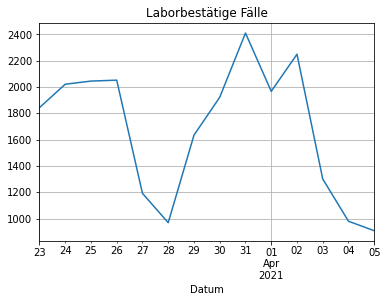

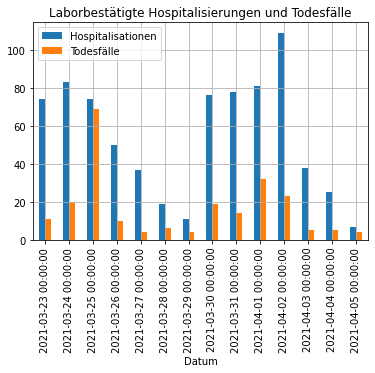

<AxesSubplot:title={'center':'Laborbestätigte Hospitalisierungen und Todesfälle'}, xlabel='Datum'>

In [9]:
# Out charts
df = pd.DataFrame(result)
# Print data frame set as line chart
df.plot.line(x="Datum", y=["Neue Fälle"], title="Laborbestätige Fälle", grid=True, legend=False)
df.plot.bar(x="Datum", y=["Hospitalisationen","Todesfälle"], title="Laborbestätigte Hospitalisierungen und Todesfälle", grid=True)
#df.plot.area(x="Datum", y=["Hospitalisationen","Todesfälle"], title="Laborbestätigte Hospitalisierungen und Todesfälle", grid=True, legend=True, subplots=True)
#df.head()

## Südostschweiz
Code  mit <mark> Run Cell </mark> ausführen um die Südostschweiz News anzuzeigen.

In [ ]:
news = ['https://www.suedostschweiz.ch']

def newsreader(url, links=True, images=True, emphasis=True):
    '''Reads the given url and print a markdown'''
    import requests, html2text
    from datetime import datetime
    now = datetime.now()

    response = requests.get(url)
    if(response.status_code == 200):
        
        print(colors.bold + colors.fg.blue +'{1}{0}{4} {2}{0}{3}{0}'.format('\n', '>' * 100, f'NEWS FROM: {site}', '<' * 100, now.strftime("%Y-%m-%d %H:%M:%S")) + colors.reset)

        html = response.content.decode('utf-8')

        md = html2text.HTML2Text()
        md.ignore_links    = not links
        md.ignore_images   = not images
        md.ignore_emphasis = not emphasis
        md.body_width      = 100
        
        data  = md.handle(html)

        #read from '# Startseite'
        start  = data.find('# Startseite')
        end    = data.find('## 2\. GR Template Menu')
        stream = [(data[start:end])]
        
        for i in stream:
            if(i is not None):
                line = i.replace('ABO\n\n','').replace('Sponsored Content\n\n','').replace('video\n\n','').replace('bilder\n\n','').replace('Mehr\n\n','').replace('Bildergalerie\n\n','')
                print('{0}{1}{2}'.format(colors.fg.green, line, colors.reset))

        return stream

def savefile(filepath, filename, stream):
    '''Save the stream to the file'''
    import os

    if not os.path.exists(filepath):
        os.makedirs(filepath)

    file = open(filepath + '\\' + filename, 'w')
    for i in stream:
        file.write(i)

    file.close()

for site in news:
    stream = newsreader(site, False, False)
    #savefile('D:\\temp', 'somedia.md', stream)
